## Deepseek-VL2

* From Deepseek AI
* Rank #45 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)

In [1]:
# conda activate deepseek

import torch
from transformers import AutoModelForCausalLM
import sys
import os

# Add the desired directory to the Python path
sys.path.append(os.path.abspath('/data/students/earl/llava-dissector/DeepSeek-VL2'))

from deepseek_vl2.models import DeepseekVLV2Processor, DeepseekVLV2ForCausalLM
from deepseek_vl2.utils.io import load_pil_images


# specify the path to the model
model_path = "/data/students/earl/llava-dissector/DeepSeek-VL2/deepseek_vl2"
vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(model_path, 
                                                                       trust_remote_code=True,
                                                                       device_map='auto',
                                                                       torch_dtype=torch.bfloat16).eval()



/data/students/earl/anaconda3/envs/deepseek/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: downsample_ratio, ignore_id, sft_format, add_special_token, image_mean, mask_prompt, image_std, normalize, patch_size, pad_token, candidate_resolutions, image_token. 


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



DeepseekVLV2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
DeepseekV2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `

<|User|>: <image>
Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of person in the image.

<|Assistant|>: ructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corructive corru

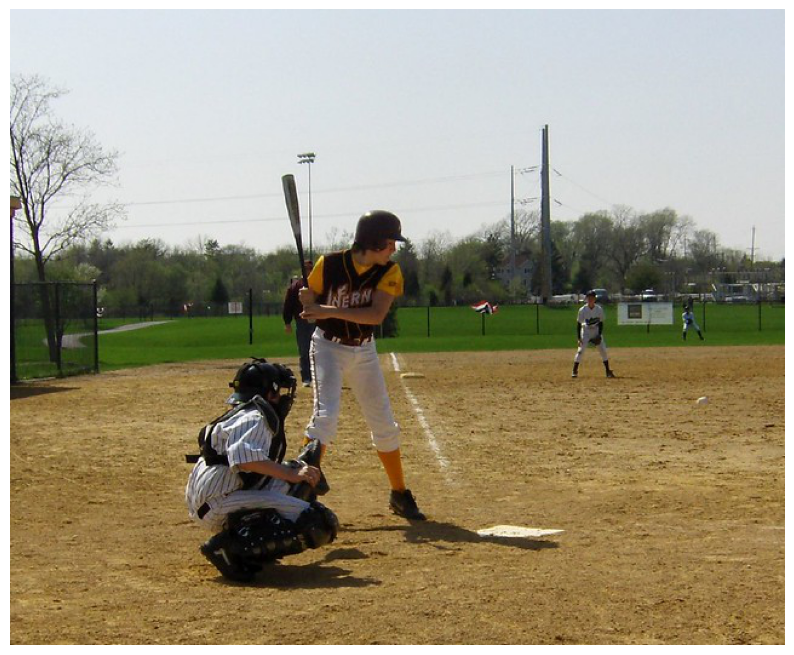

In [3]:
import cv2
import io
import re
import requests
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

cls = "person"
vl_gpt.threshold = 1.5

image_path = url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image.'


## single image conversation example
conversation = [
    {
        "role": "<|User|>",
        #"content": f"<image>\nGive the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of <|det|>{cls}<|/det|> in the image.",
        "content": f"<image>\n{text}",
        "images": [image_path],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# run the model to get the response
outputs = vl_gpt.language.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

response = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", response)

# regex the part of string to extract bounding boxes
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    # Each match is a tuple of 8 elements, only 4 will be filled
    coords = [c for c in match if c != '']
    if len(coords) == 4:
        bounding_boxes.append([float(c) for c in coords])
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(io.BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
